<a href="https://colab.research.google.com/github/MatanTsarfaty/AML/blob/main/Word2Vec_with_LogReg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Word2Vec: https://www.kaggle.com/code/vladislavkisin/word2vec-in-supervised-nlp-tasks-shortcut/notebook

In [107]:
##data_dir = '/content/drive/My Drive/Advance ML/Final Project/'
test_csv = 'https://raw.githubusercontent.com/MatanTsarfaty/AML/main/Copy%20of%20dreaddit-test.csv'
train_csv = 'https://raw.githubusercontent.com/MatanTsarfaty/AML/main/Copy%20of%20dreaddit-train.csv'

In [108]:
import pandas as pd
import numpy as np
import plotly.express as px 
import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, VarianceThreshold, mutual_info_classif, SelectKBest

In [109]:
import re
import nltk
nltk.download('punkt')
import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [110]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from gensim.models import word2vec, Word2Vec

In [111]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

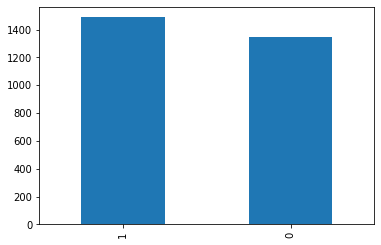

In [112]:
train_df['label'].value_counts().plot(kind='bar')

In [113]:
train_df.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [114]:
values = train_df['subreddit'].value_counts()
labels = train_df['subreddit'].value_counts().index

fig = px.pie(train_df, names=labels, values=values)
fig.update_layout(title='Subreddits distribution')
fig.update_traces(hovertemplate='%{label}: %{value}')
fig.show()

In [115]:
train_df['subreddit']

0                   ptsd
1             assistance
2                   ptsd
3          relationships
4       survivorsofabuse
              ...       
2833       relationships
2834                ptsd
2835             anxiety
2836      almosthomeless
2837                ptsd
Name: subreddit, Length: 2838, dtype: object

In [116]:
label_enc = LabelEncoder()
train_df['subreddit'] = label_enc.fit_transform(train_df['subreddit'])
test_df['subreddit'] = label_enc.fit_transform(test_df['subreddit'])

In [117]:
train_df['subreddit']

0       6
1       2
2       6
3       7
4       9
       ..
2833    7
2834    6
2835    1
2836    0
2837    6
Name: subreddit, Length: 2838, dtype: int64

Take all the 80% majurity data

In [118]:
BestData_ = train_df[train_df['confidence'] >= 0.8]

In [119]:
BestData_.shape

(1852, 116)

In [120]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [121]:
import re

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def nospecial(text, remove_spaces=True):
    #return re.sub('[^a-zA-Z0-9 ]', " ", text)
    return re.sub('[^a-zA-Z ]', "", text)

def clean_text(text):
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    text = nospecial(text)
    return text

In [122]:
# Here we get transform the documents into sentences for the word2vecmodel
# we made a function such that later on when we make the submission, we don't need to write duplicate code
def preprocess(df):
    df['text'] = df['text'].apply(clean_text)
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.') 
    df['tokenized_sentences'] = list(map(lambda sentences: list(map(nltk.word_tokenize, sentences)), df.document_sentences))  
    df['tokenized_sentences'] = list(map(lambda sentences: list(filter(lambda lst: lst, sentences)), df.tokenized_sentences))

In [123]:
preprocess(BestData_)
preprocess(test_df)

In [124]:
#Collecting a vocabulary
voc = []
for sentence in BestData_.tokenized_sentences:
    voc.extend(sentence)

print("Number of sentences: {}.".format(len(voc)))
print("Number of rows: {}.".format(len(BestData_)))

Number of sentences: 1852.
Number of rows: 1852.


Word2Vec model

In [125]:
num_features = 260    
min_word_count = 3
num_workers = 4
context = 8
downsampling = 1e-3

# Initialize and train the model
W2Vmodel = Word2Vec(sentences=voc, sg=1, hs=0, workers=num_workers, size=num_features, min_count=min_word_count, window=context,
                    sample=downsampling, negative=5, iter=10)

In [126]:
def sentence_vectors(model, sentence):
    #Collecting all words in the text
    words=np.concatenate(sentence)
    #Collecting words that are known to the model
    model_voc = set(model.wv.vocab.keys()) 
    sent_vector = np.zeros(model.vector_size, dtype="float32")
    # Use a counter variable for number of words in a text
    nwords = 0
    # Sum up all words vectors that are know to the model
    for word in words:
        if word in model_voc: 
            sent_vector += model[word]
            nwords += 1.

    # Now get the average
    if nwords > 0:
        sent_vector /= nwords
    return sent_vector

In [127]:
BestData_['sentence_vectors'] = list(map(lambda sen_group: sentence_vectors(W2Vmodel, sen_group), BestData_.tokenized_sentences))
test_df['sentence_vectors'] = list(map(lambda sen_group:sentence_vectors(W2Vmodel, sen_group), test_df.tokenized_sentences))

In [128]:
def vectors_to_feats(df, ndim):
    index=[]
    for i in range(ndim):
        df[f'w2v_{i}'] = df['sentence_vectors'].apply(lambda x: x[i])
        index.append(f'w2v_{i}')
    return df[index]

In [129]:
X_train_Word2Vec = vectors_to_feats(BestData_, num_features)
X_test_Word2Vec = vectors_to_feats(test_df, num_features)
X_train_Word2Vec.head()

,w2v_0,w2v_1,w2v_2,w2v_3,w2v_4,w2v_5,w2v_6,w2v_7,w2v_8,w2v_9,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,0.023576,0.181576,-0.166946,0.272200,0.008710,-0.037849,-0.035544,0.089335,-0.001131,0.084395,...,-0.005882,0.032905,0.017526,-0.004856,-0.063663,-0.052774,-0.068103,-0.076675,-0.012993,0.083135
1,0.013865,0.132555,-0.118585,0.229888,-0.044499,0.007656,0.046725,0.076669,-0.074793,0.117652,...,-0.037058,0.050323,0.057518,0.104145,-0.154829,-0.079251,-0.036416,-0.107833,-0.074089,0.037889
2,0.024403,0.186959,-0.136917,0.276266,-0.013662,-0.045711,-0.050662,0.084227,-0.008208,0.124143,...,0.005549,0.027449,0.036540,-0.001663,-0.074913,-0.005632,-0.053810,-0.060712,-0.003625,0.094116
4,0.008776,0.224188,-0.101339,0.246772,-0.022410,-0.038940,-0.030366,0.110026,0.004731,0.118435,...,0.005980,0.015294,0.015786,0.037195,-0.066156,-0.028064,-0.048410,-0.064559,0.010979,0.075593
5,0.051846,0.198033,-0.205374,0.323768,-0.017394,-0.051601,-0.064626,0.072651,0.001185,0.119647,...,-0.014133,0.050247,0.042423,-0.009894,-0.075677,-0.007286,-0.056705,-0.086137,-0.001961,0.093642


In [130]:
test_df.head()

,id,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,social_karma,syntax_ari,...,w2v_250,w2v_251,w2v_252,w2v_253,w2v_254,w2v_255,w2v_256,w2v_257,w2v_258,w2v_259
0,896,7,7nu7as,"[50, 55]",its like that want not me i problem takes long...,0,0.8,1.514981e+09,22,-1.238793,...,-0.003394,0.054186,0.030437,-0.022768,-0.069039,-0.044166,-0.060607,-0.090185,-0.016626,0.074659
1,19059,1,680i6d,"(5, 10)",i man front desk title hr customer service rep...,0,1.0,1.493348e+09,5,7.684583,...,-0.015594,0.038736,0.018993,0.036558,-0.106824,-0.043144,-0.032006,-0.077721,-0.018239,0.051893
2,7977,6,8eeu1t,"(5, 10)",wed saving much money new housrits expensive c...,1,1.0,1.524517e+09,10,2.360408,...,-0.001336,0.056352,0.023122,-0.002222,-0.079728,-0.036055,-0.049744,-0.079536,-0.001106,0.086829
3,1214,6,8d28vu,"[2, 7]",my ex used shoot back do want go you time matt...,1,0.5,1.524018e+09,5,5.997000,...,-0.010431,0.034891,0.030793,-0.014394,-0.058722,-0.031522,-0.077002,-0.070155,-0.007294,0.094556
4,1965,7,7r1e85,"[23, 28]",i havent said anything yet im sure someone wou...,0,0.8,1.516200e+09,138,4.649418,...,-0.004934,0.026600,0.035837,-0.004606,-0.081464,-0.025340,-0.067969,-0.072066,-0.010333,0.086916


In [131]:
y_train = BestData_['label']
X_train = BestData_.drop('label', axis=1)

In [132]:
y_test = test_df['label']
X_test = test_df.drop('label', axis=1)

In [133]:
X_train = X_train.select_dtypes(include=np.number)

In [134]:
X_test = X_test.select_dtypes(include=np.number)

In [135]:
X_train.shape

(1852, 372)

In [136]:
def best_model(X_train, y_train, X_test, y_test, scaler, algo):
        
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    model = algo()
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    training_score = model.score(X_train, y_train)
    acc = accuracy_score(y_test, predictions)
    con = confusion_matrix(y_test, predictions)
    report = classification_report(y_test, predictions)
    print(f'Training Score: {training_score}')
    print(f'Accuracy Score: {acc}')
    print(" ")
    print('Confusion Matrix:')
    print(con)
    print(" ")
    print('Classification Report:')
    print(report)

## Pearson correlation method

In [137]:
def correlation(df, thres): #Dataset and threshold value
    col_corr = set()
    corr_matrix = df.corr(method='pearson')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= thres:
                colname = corr_matrix.columns[i]
                col_corr.add(colname)
    return col_corr

In [138]:
corr_features = correlation(X_train, 0.4)

In [139]:
len(corr_features)

318

In [140]:
X_train[corr_features]

,w2v_130,w2v_227,w2v_197,w2v_27,lex_liwc_sad,lex_liwc_compare,w2v_150,w2v_26,w2v_195,w2v_33,...,lex_liwc_male,w2v_72,lex_liwc_pronoun,w2v_101,w2v_257,lex_liwc_motion,w2v_62,w2v_89,syntax_fk_grade,w2v_165
0,-0.031035,-0.143470,-0.036221,0.006826,3.45,3.45,0.098297,-0.017036,0.026989,-0.050220,...,1.72,0.023501,16.38,-0.180275,-0.076675,0.86,0.003832,-0.133204,3.253573,-0.042759
1,-0.041044,-0.124711,-0.032520,-0.065932,0.00,0.92,0.114446,0.020871,0.018769,-0.037426,...,0.00,-0.041382,11.93,-0.153246,-0.107833,2.75,0.003661,-0.143994,8.828316,-0.116182
2,-0.085637,-0.155712,-0.025098,-0.004165,0.00,0.60,0.105952,0.002580,0.024266,-0.069485,...,2.40,0.027612,25.15,-0.136508,-0.060712,4.79,-0.029850,-0.107887,7.841667,-0.070646
4,-0.080880,-0.118115,-0.038892,-0.019631,0.00,2.25,0.097751,0.009028,0.050022,-0.092850,...,4.49,0.012724,15.73,-0.148879,-0.064559,2.25,-0.034227,-0.118463,7.910952,-0.053670
5,-0.034655,-0.145919,-0.051749,-0.007004,1.90,1.90,0.090397,0.006782,-0.001886,-0.054475,...,3.81,0.043785,20.95,-0.147124,-0.086137,1.90,0.024347,-0.112265,4.338429,-0.090014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2829,-0.059140,-0.086145,-0.056640,-0.025397,0.00,1.37,0.101533,0.040356,0.016805,-0.082840,...,2.74,-0.024326,9.59,-0.162500,-0.072456,4.11,-0.046135,-0.095613,5.993333,-0.043645
2831,-0.036835,-0.132340,-0.043749,0.003044,0.00,2.34,0.124019,0.020689,0.044670,-0.060404,...,3.91,0.046885,24.22,-0.146130,-0.080185,1.56,-0.054394,-0.080158,10.250250,-0.069471
2833,-0.155620,-0.154338,-0.043139,-0.042911,0.00,3.37,0.081161,0.013750,-0.019371,-0.127866,...,0.00,-0.011850,25.84,-0.105458,-0.046845,2.25,-0.025333,-0.107810,0.254444,-0.090399
2834,0.065038,-0.149209,-0.062214,0.024109,0.74,1.48,0.095134,0.002308,0.018110,-0.012636,...,0.00,0.066044,16.30,-0.217978,-0.123561,2.22,0.019982,-0.136570,8.640664,-0.076501


In [141]:
minmax = MinMaxScaler()

In [142]:
best_model(X_train[corr_features], y_train, X_test[corr_features], y_test, minmax, LogisticRegression)

Training Score: 0.8617710583153347
Accuracy Score: 0.7678321678321678
 
Confusion Matrix:
[[242 104]
 [ 62 307]]
 
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.70      0.74       346
           1       0.75      0.83      0.79       369

    accuracy                           0.77       715
   macro avg       0.77      0.77      0.77       715
weighted avg       0.77      0.77      0.77       715



# Until here is the implementation of the article.

## Now we will use cross-validation to evaluate the model

In [143]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

In [144]:
x_full_data = pd.concat((X_train, X_test), sort=False).reset_index(drop=True)
y_full_data = pd.concat((y_train, y_test), sort=False).reset_index(drop=True)

In [145]:
def get_models():
  
    models = dict()
    models['lr'] = make_pipeline(StandardScaler(),LogisticRegression(solver = 'saga', C = 1.0))
    models['svm'] = make_pipeline(StandardScaler(),SVC())
    models['xgboost'] = XGBClassifier(n_estimators = 17, max_depth = 2)
    
    return models

In [146]:
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=7, n_repeats=3, random_state=42)
	scores = cross_val_score(model, X, y, scoring='f1', cv=cv, n_jobs=-1, error_score='raise')
	return scores

> Model: lr F1 score is 0.83, with a standard deviation of (0.02)
> Model: svm F1 score is 0.83, with a standard deviation of (0.02)
> Model: xgboost F1 score is 0.82, with a standard deviation of (0.01)


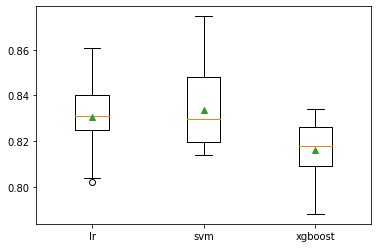

In [147]:
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import mean
from numpy import std

models = get_models()

# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, x_full_data, y_full_data)
	results.append(scores)
	names.append(name)
	print('> Model: %s F1 score is %.2f, with a standard deviation of (%.2f)' % (name, scores.mean(), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()